## Data Exploration of Breast Cancer by Stage

##### For this interview problem, you will be investigating a breast cancer data set from a tumor micro array where each row is a tumor sample from a patient. These tumor samples were then analyzed to segment cells and determine how many of those cells are positive for each biomarker/biomarker combination. These numbers were then normalized to total cells and by specific cell subtypes. Additionally, a spatial analysis was performed on each sample to determine the distance of certain cell types to other cell types. To analyze this data set, you are asked to investigate the data by the stage of the cancer category, and will be asked to:
##### Find the 10 most important features contributing to the variance in the stage of cancer.
##### Run a PCA and find the first 2 principal components and plot them against each other and color code the points by stage.

##### Bonus points if you can make a confidence ellipse that fits the points for each stage of cancer on the PCA plot.

##### Notes: The data is organized in way where each column is a measurement, and each row is a sample. The metadata containing the stage information is in the middle of the data sheet.


#### Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
#import plotly.express as px

#### Functions

In [2]:
def confidence_ellipse(x, y, ax, n_std, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

#### Read Data

In [3]:
data= pd.read_csv("Test_Breast_Cancer_Data_Set.csv")
data.shape

(89, 202)

#### Data Cleaning and Filtering 

In [4]:
df = data[data.columns.drop(list(data.filter(regex='%')))]
df = df.loc[:, (df != 0).any(axis=0)]
df.shape

(89, 98)

In [5]:
df_normalized= df 
df_normalized = df_normalized.fillna(0)
df_normalized = pd.DataFrame(df_normalized.select_dtypes(include=np.number))
df_normalized.shape

(89, 92)

In [6]:
metadata = pd.DataFrame(df.select_dtypes(exclude=["number","bool_"]))
metadata.shape

(89, 6)

#### Important Features

##### Correlation graph

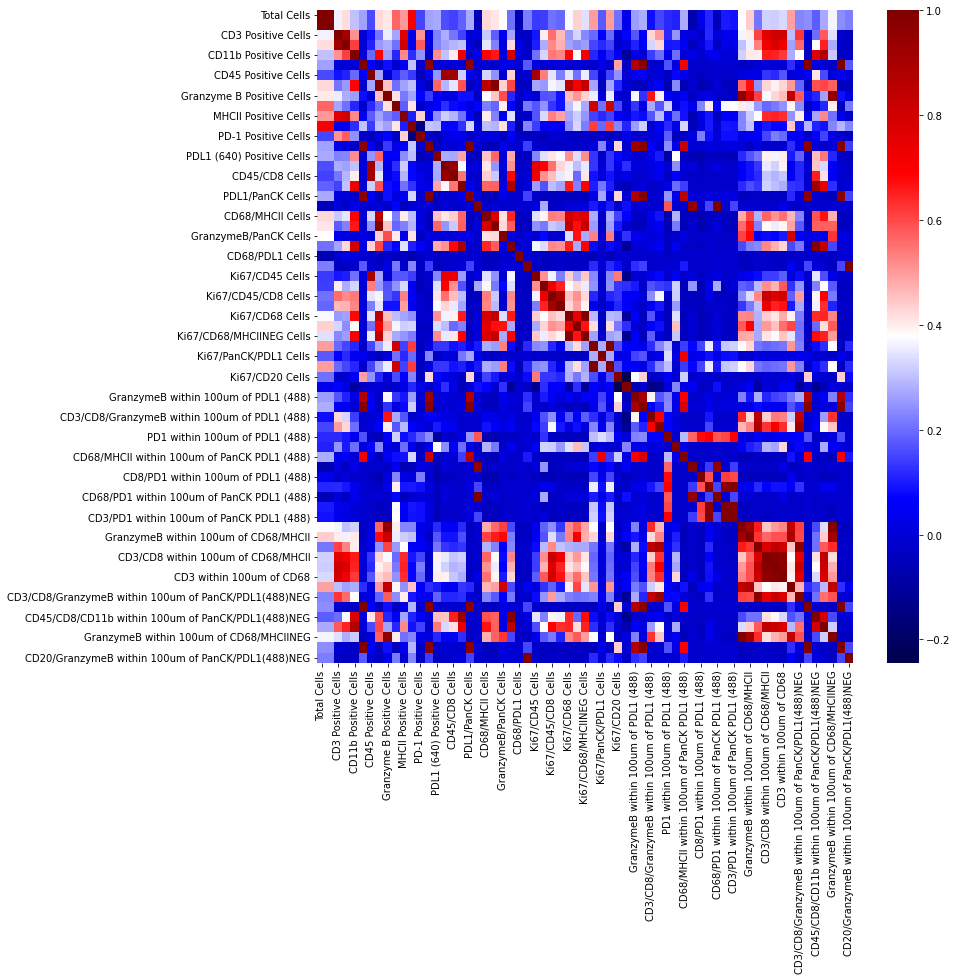

In [7]:
#Using Pearson Correlation
plt.figure(figsize=(12,12))
df_normalized_1 = df_normalized[df_normalized.columns.drop(list(df_normalized.filter(regex='Average')))]
cor = (df_normalized_1.corr())
sns.heatmap(cor, cmap="seismic")
plt.show()

##### Getting Top Features using correlation values

In [8]:
df_normalized_1.shape

(89, 65)

In [9]:
#Feature Matrix as Total Cells
X = df_normalized_1.drop("Total Cells",1) 
y = df_normalized_1["Total Cells"]
#Correlation with output variable
cor_target = abs(cor["Total Cells"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features.sort_values(ascending=False)

/tmp/ipykernel_131912/2587091604.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_normalized_1.drop("Total Cells",1)


Total Cells                                     1.000000
DAPI Positive Cells                             1.000000
PanCK Positive Cells                            0.704069
Ki67 Positive Cells                             0.562696
MHCII Positive Cells                            0.503041
Ki67/PanCK Cells                                0.498719
Ki67/PanCK/PDL1NEG Cells                        0.498395
GranzymeB within 100um of PanCK/PDL1(488)NEG    0.490799
GranzymeB within 100um of CD68/MHCII            0.439614
Ki67/CD68/MHCII Cells                           0.436138
CD68 Positive Cells                             0.423950
CD68/MHCII Cells                                0.422147
CD8 Positive Cells                              0.418341
CD68/MHCIINeg Cells                             0.408087
Granzyme B Positive Cells                       0.402848
Name: Total Cells, dtype: float64

#### PCA Processing

In [10]:
pca = PCA(2)
pca.fit(df_normalized_1)
pca_samples = pca.transform(df_normalized_1)
pca_samples = StandardScaler().fit_transform(pca_samples)

##### Creating Stage IDs for segrgation

In [11]:
labels = np.array(metadata['Stage'])
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in labels])

##### Creating Variance Ratio Table

In [12]:
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
pca_df

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.874172,0.874172
1,0.949438,0.075266


##### PCA Plot for Different Stages

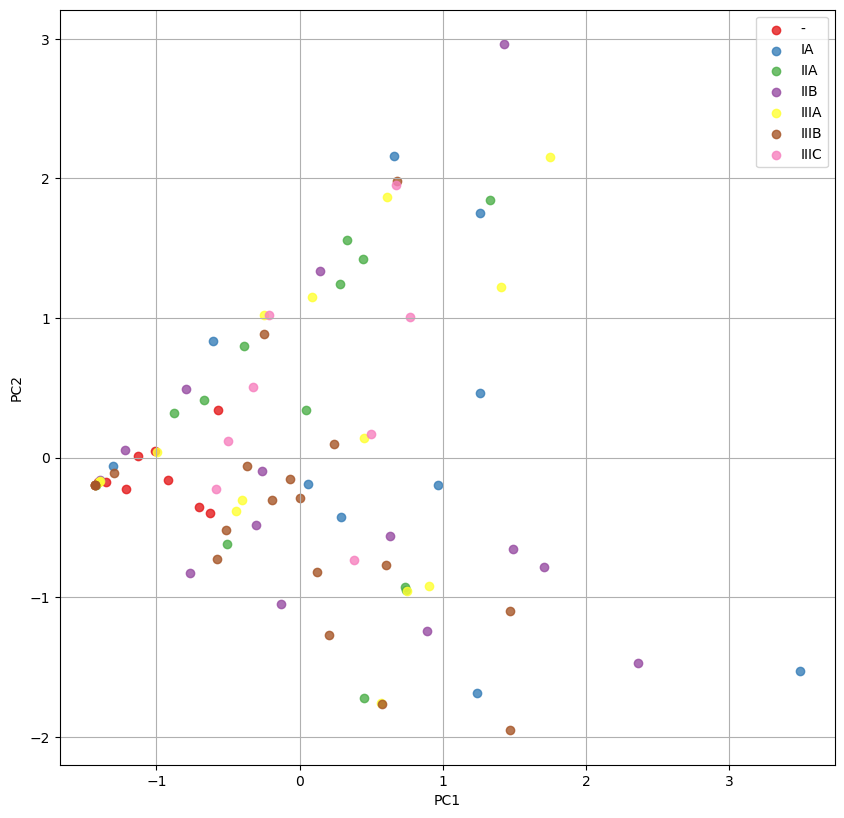

In [13]:
plt.figure(figsize=(10,10),dpi=100)
plt.grid()

nb_classes = len(np.unique(label_ids))

for label_id in np.unique(label_ids):
    plt.scatter(pca_samples[np.where(label_ids == label_id), 0],
                pca_samples[np.where(label_ids == label_id), 1],
                marker='o',
                color= plt.cm.Set1(label_id / float(nb_classes)),
                linewidth=1,
                alpha=0.8,
                label=id_to_label_dict[label_id])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')

##### PCA Plot for Different Stages and Confidence Ellipse 

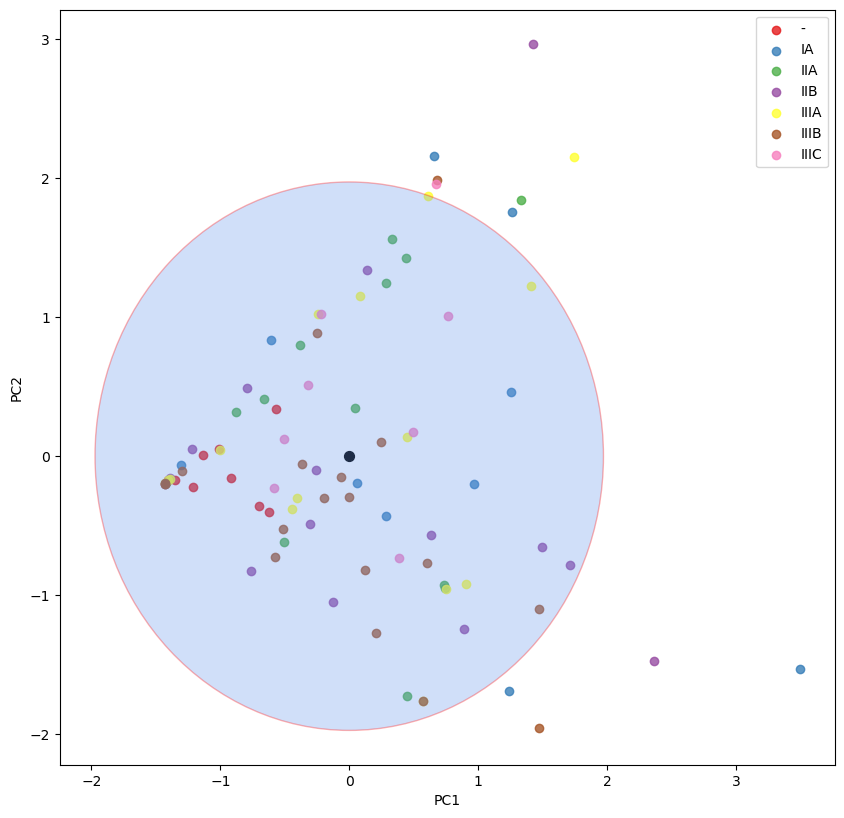

In [14]:
pca_data = pd.DataFrame(pca_samples)
X = pca_data[0]
y = pca_data[1]
fig = plt.figure(figsize = (10,10),dpi=100)
ax = fig.add_subplot()

for label_id in np.unique(label_ids):
    ax.scatter(pca_samples[np.where(label_ids == label_id), 0],
                pca_samples[np.where(label_ids == label_id), 1],
                marker='o',
                color= plt.cm.Set1(label_id / float(nb_classes)),
                linewidth=1,
                alpha=0.8,
                label=id_to_label_dict[label_id])
ax.scatter(np.mean(X),np.mean(y), color='Black', s=50)
confidence_ellipse(X,y,ax,n_std=1.96,edgecolor='red', 
                   facecolor='cornflowerblue', alpha=0.3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.legend(loc='best')
plt.show()